In [1]:
from sklearn.model_selection import train_test_split
import random
from glob import glob
import json

In [2]:
# def load_file(path):
#     with open(path, "r", encoding="utf-8") as f:
#         data = []
#         for line in f.readlines():
#             json_obj = json.loads(line)
#             data.append(json_obj)
#     return data

def load_file(path, max_context=7):
    with open(path, "r", encoding="utf-8") as f:
        data = []
        for line in f.readlines():
            json_obj = json.loads(line.strip())
            query = json_obj["query"]
            passages = []
            mark, count = 0, 0
            
            for passage in json_obj["passages"]:
                if count > max_context:
                    break
                if passage["is_selected"] == 1:
                    if mark == 1:
                        continue
                    passages.append(passage)
                    mark = 1
                else:
                    if len(passages) == max_context and mark == 0:
                        continue
                    passages.append(passage)
                count+=1
                                
            random.shuffle(passages)
                
            if mark == 1:
                sample = {
                    "query":query,
                    "passages":passages
                }
                # sample = json.dumps(sample, ensure_ascii=False)
                data.append(sample)
    return data

def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

def load_data(path):
    data = []
    for _file in glob(path+"/*.json"):
        data += load_file(_file)
      
    return data


In [3]:
path = "/home/tuyendv/Desktop/mbf_ir/data/processed-ir-data/train"
data = load_data(path)

In [4]:
random.shuffle(data)
train, valid = train_test_split(data, test_size=0.05, random_state=42)
print("train: ", len(train))
print("val: ", len(valid))

train:  322925
val:  16997


In [5]:
def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

data_size = 50000
n = int(len(train)/data_size) + 1

for i in range(n):
    path = f"/home/tuyendv/Desktop/mbf_ir/data/qa_data/train/{str(i).zfill(6)}.json"
    save_data(path, data=train[i*data_size:(i+1)*data_size])

In [6]:
save_data("/home/tuyendv/Desktop/mbf_ir/data/qa_data/val/000000.json", data=valid)

In [7]:
path = "/home/tuyendv/Desktop/mbf_ir/data/processed-ir-data/test"
data = load_data(path)

In [8]:
save_data("/home/tuyendv/Desktop/mbf_ir/data/qa_data/test/000000.json", data=data)

### statis

In [ ]:
import json

In [ ]:
def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

In [ ]:
path = "/home/tuyendv/Desktop/reranker/data/raw/squad-train-v2.0-en.json"
data = json.load(open(path))

In [ ]:
msmacro_data = []
for text in data["data"]:
    for paragraph in text["paragraphs"]:
        passage = paragraph["context"]
        for sample in paragraph["qas"]:
            query = sample["question"]
            
            _temp = {
                "query": query,
                "passage": passage
            }
            msmacro_data.append(_temp)

In [ ]:
save_data("/home/tuyendv/Desktop/reranker/data/ir/train/squad-train-v2.0-en.json", msmacro_data)

### vi_squad

In [ ]:
%cd /home/tuyendv/Desktop/reranker
import json
import pandas as pd
from bm25 import BM25
from tqdm import tqdm
from utils import save_data, load_file

In [ ]:
path = "/home/tuyendv/Desktop/reranker/data/raw/squad-train-v2.0-en.json"
data = load_file(path)

df = pd.DataFrame(data, columns=["passage", "query", "answer"])
df.head()

In [ ]:
passages = []
for i, doc in enumerate(df.passage.unique().tolist()):
    _id = str(i).zfill(6)
    _text = doc
    
    passages.append([_id, _text])
    
passages = pd.DataFrame(passages, columns=["id", "passage_text"])
passages.head()

In [ ]:
bm25 = BM25()
bm25.train(passages)

In [ ]:
data = []
for index in tqdm(df.index):
    query = df["query"][index]
    positive_passage = df["passage"][index]
    all_passage = bm25.ranking(positive_passage, top_k=8)["retrieval_text"].tolist()
    
    passages = []
    mark = 0
    for passage in all_passage:
        if positive_passage == passage:
            sample = {
                "is_selected":1,
                "passage_text":passage
            }
            mark = 1
        else:
            sample = {
                "is_selected":0,
                "passage_text":passage
            }
        passages.append(sample)
        
    if mark == 0:
        sample = {
            "is_selected":1,
            "passage_text":positive_passage
        }
        passages.append(sample)
    
    data.append(
        {
            "query":query,
            "passages":passages
        }
    )

In [ ]:
path = "/home/tuyendv/Desktop/reranker/data/ir/train/squad-train-v2.0-en.json"
save_data(path, data=data)

### vi_data

In [ ]:
import pandas as pd
import json

In [ ]:
path = "/home/tuyendv/Desktop/reranker/data/raw/vi_data.json"
df = pd.read_json(path)
df.head()

In [ ]:
data = []
for index in df.index:
    query = df["question"][index]
    positive = df["positive_sample"][index]
    negative_samples = df["negative_samples"][index]
    
    passages = []
    
    passages.append(
        {
            "passage_text":positive,
            "is_selected":1
        }
    )
    
    for negative in negative_samples:
        passages.append(
            {
                "passage_text":negative,
                "is_selected":0
            }
        )
        
    data.append(
        {
            "query":query,
            "passages":passages
        }
    )

In [ ]:
def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

path="/home/tuyendv/Desktop/reranker/data/ir/vi_data.json"
save_data(path, data)

### v1

In [ ]:
import json

In [ ]:
path = "/home/tuyendv/Desktop/reranker/data/ir/train/ms-macro-train_v1.1.json"

data = []
with open(path, "r", encoding="utf-8") as f:
    for line in f.readlines():
        line = json.loads(line.strip())
        passages = [
            {
                "passage_text":i["passage_text"],
                "is_selected":i["is_selected"]
                } for i in line["passages"]
            ]
        data.append(
            {
                "query":line["query"],
                "passages":passages
            }
        )

In [ ]:
def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

path = "/home/tuyendv/Desktop/reranker/data/ir/train/ms-macro-train_v1.1.json"
save_data(path, data[0:30000])

### process data

In [1]:
%cd /home/tuyendv/Desktop/reranker/
import json
import pandas as pd
from utils import load_file, load_data

/home/tuyendv/Desktop/reranker


In [2]:
path = '/home/tuyendv/Desktop/mbf_ir/data/qa_data/test'
data = load_data(path)

In [3]:
df = pd.DataFrame(data)
df.head()

,0
0,"{""query"": "" Tập đoàn Vingroup được thành lập v..."
1,"{""query"": "" Tiền thân của Vingroup là công ty ..."
2,"{""query"": "" Thương hiệu mỳ của Vingroup được m..."
3,"{""query"": "" Công ty cổ phần Vinpearl và công t..."
4,"{""query"": "" Cổ phiếu Vingroup phát hành thêm c..."


In [4]:
def get_length(query, passages):
    query_length = len(query.split())
    
    lengths = []
    for pa in passages:
        tmp = pa["passage_text"]
        
        lengths.append(len(tmp.split()) + query_length)
        
    return lengths

df["length"] = df.apply(lambda x: get_length(x["query"], x["passages"]), axis=1)

KeyError: 'query'

In [ ]:
df["num_pass"] = df.passages.apply(lambda x: len(x))
df.head()

In [ ]:
lengths = [i for j in df.length.tolist() for i in j]
pd.DataFrame(lengths, columns=["lengths"]).lengths.hist(bins=100)

### temp

In [3]:
import os 
from glob import glob
import json
import pandas as pd
import random

In [4]:
# def load_file(path):
#     with open(path, "r", encoding="utf-8") as f:
#         data = []
#         for line in f.readlines():
#             json_obj = json.loads(line)
#             data.append(json_obj)
#     return data

def load_file(path, max_context=7):
    with open(path, "r", encoding="utf-8") as f:
        data = []
        for line in f.readlines():
            json_obj = json.loads(line.strip())
            query = json_obj["query"]
            passages = []
            mark, count = 0, 0
            
            for passage in json_obj["passages"]:
                if count > max_context:
                    break
                if passage["is_selected"] == 1:
                    if mark == 1:
                        continue
                    passages.append(passage)
                    mark = 1
                else:
                    if len(passages) == max_context and mark == 0:
                        continue
                    passages.append(passage)
                count+=1
                                
            random.shuffle(passages)
                
            if mark == 1:
                sample = {
                    "query":query,
                    "passages":passages
                }
                # sample = json.dumps(sample, ensure_ascii=False)
                data.append(sample)
    return data

def save_data(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for sample in data:
            json_obj = json.dumps(sample, ensure_ascii=False)
            f.write(json_obj+"\n")

def load_data(path):
    data = []
    for _file in glob(path+"/*.json"):
        data += load_file(_file)
      
    return data


In [5]:
path = "/home/tuyendv/Desktop/mbf_ir/data/qa_data/train"
data = load_data(path)
len(data)

322925

In [6]:
data= pd.DataFrame(data)
data.head()

,query,passages
0,Ở thành phố nào có nhiều người Trung Quốc sống...,"[{'is_selected': 1, 'passage_text': 'Khoảng đầ..."
1,The amount of red in mandrill males is directl...,"[{'is_selected': 0, 'passage_text': '1900s. Sp..."
2,how many years in prison did wesley snipes get,[{'passage_text': 'CNN reported: “Actor Wesley...
3,which neurotransmitter is affected by caffeine,[{'passage_text': 'Caffeine achieves many of i...
4,What was the date on the attack of Pearl Harbor?,"[{'is_selected': 1, 'passage_text': 'Before Wo..."


In [7]:
def get_length(query, passages):
    query_length = len(query.split())
    
    lengths = []
    for pa in passages:
        tmp = pa["passage_text"]
        
        lengths.append(len(tmp.split()) + query_length)
        
    return lengths

def get_num_positive(passages):
    count = 0
    for passage in passages:
        if passage["is_selected"] == 1:
            count += 1
            
    return count

data["length"] = data.apply(lambda x: get_length(x["query"], x["passages"]), axis=1)
data["num_passage"] = data.passages.apply(lambda x: len(x))
data["num_positive_passage"] = data.passages.apply(lambda x: get_num_positive(x))

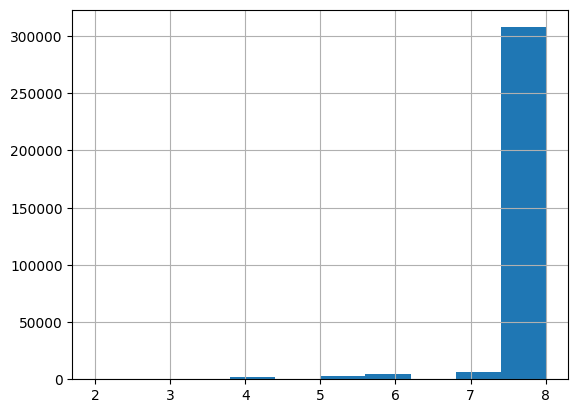

In [8]:
data["num_passage"].hist()

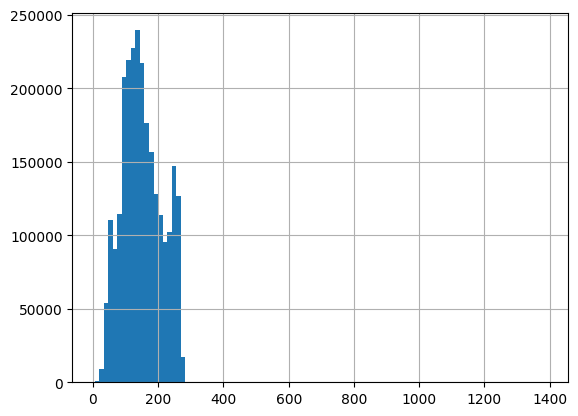

In [10]:
lengths = [i for j in data.length.tolist() for i in j]
pd.DataFrame(lengths, columns=["lengths"]).lengths.hist(bins=100)

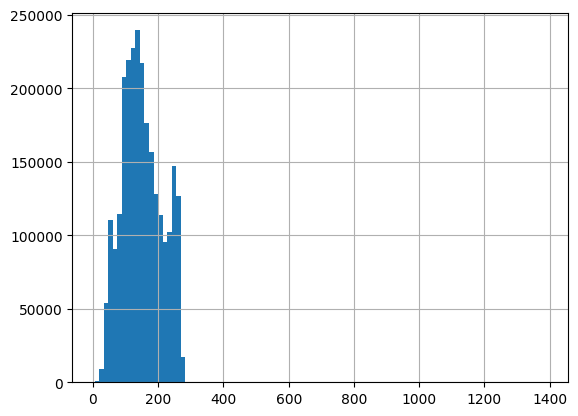

In [11]:
lengths = [i for j in data.length.tolist() for i in j]
pd.DataFrame(lengths, columns=["lengths"]).lengths.hist(bins=100)